In [2]:
DELETE = True
if DELETE:
    !rm -rf *
    print("Delete all...")

Delete all...


In [3]:
!pip install gputil


  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=b526104cee9d813d03e5ba8a3883b86910510f5a338e4f7d68fa3d6dcf999494
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built gputil


In [4]:
!git clone https://github.com/isl-org/DPT.git

# Download models and weights
#!wget https://github.com/intel-isl/DPT/releases/download/1_0/dpt_hybrid-midas-501f0c75.pt
#!wget https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt
#!wget https://github.com/intel-isl/DPT/releases/download/1_0/dpt_hybrid-ade20k-53898607.pt
!wget https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-ade20k-b12dca68.pt
    
# Import weights
#!mv ./dpt_hybrid-ade20k-53898607.pt ./DPT/weights
!mv ./dpt_large-ade20k-b12dca68.pt ./DPT/weights
#!mv ./dpt_large-midas-2f21e586.pt ./DPT/weights
#!mv ./dpt_hybrid-midas-501f0c75.pt ./DPT/weights

# Pip install required libraries with last releases
!pip install torch
!pip install torchvision
!pip install opencv-python
!pip install timm

Cloning into 'DPT'...
remote: Enumerating objects: 782, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 782 (delta 144), reused 113 (delta 113), pack-reused 606 (from 1)
Receiving objects: 100% (782/782), 458.16 KiB | 4.77 MiB/s, done.
Resolving deltas: 100% (371/371), done.
--2025-06-17 02:39:23--  https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-ade20k-b12dca68.pt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/isl-org/DPT/releases/download/1_0/dpt_large-ade20k-b12dca68.pt [following]
--2025-06-17 02:39:23--  https://github.com/isl-org/DPT/releases/download/1_0/dpt_large-ade20k-b12dca68.pt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... No data received.
Retrying.

--2025-06-17 02:39:25--  (try: 2)  ht

In [5]:
!ls

DPT


In [6]:
!cd ../input/dataset-v1/d1/ && ls

informative_signal  prevention_sign  regulation_sign


In [7]:
import os 
def initialize_system():
    # Generate output directory
    if(not(os.path.isdir('/kaggle/working/output'))):
        os.mkdir('/kaggle/working/output')
    
    filename = "/kaggle/working/DPT/run_monodepth.py"
    text = open(filename).read()
    open(filename, "w+").write(text.replace('"output_monodepth"', '"/kaggle/working/DPT/output_monodepth"'))

    filename = "/kaggle/working/DPT/run_segmentation.py"
    text = open(filename).read()
    open(filename, "w+").write(text.replace('"output_semseg"', '"/kaggle/working/DPT/output_semseg"'))
    
    filename = "/kaggle/working/DPT/run_monodepth.py"
    text = open(filename).read()

    #Here goes your files
    open(filename, "w+").write(text.replace('"input"', '"/kaggle/working/DPT/input/"'))

    filename = "/kaggle/working/DPT/run_segmentation.py"
    text = open(filename).read()

    #Here goes your files
    open(filename, "w+").write(text.replace('"input"', '"/kaggle/working/DPT/input/"'))
    
    filename = "/kaggle/working/DPT/run_monodepth.py"
    text = open(filename).read()
    open(filename, "w+").write(text.replace('"weights/', '"/kaggle/working/DPT/weights/'))

    filename = "/kaggle/working/DPT/run_segmentation.py"
    text = open(filename).read()
    open(filename, "w+").write(text.replace('"weights/', '"/kaggle/working/DPT/weights/'))

In [8]:
initialize_system()

In [9]:
# Training parameters
dropout = 0.1
activation = "GELU"
weight_decay = 0.0
early_stopping = True
learning_rate = 1e-4
batch_size = 4
epochs = 25
optimizer_selected = "AdamW"
scheduler_selected = "ReduceLROnPlateau"#"StepLR"
criterion_selected = "CrossEntropy"
DATASET_PATH = "../input/dataset-v2/d2/"#"../input/dataset-v2/d2/"

In [10]:
with open("DPT/dpt/models.py", "r") as f:
    code = f.read()
# Paso 1: Reemplazar la línea de Dropout fija por una variable
code = code.replace("nn.Dropout(0.1, False)", "dropout_layer")
#code = code.replace("dropout_layer,", "dropout_layer")
if activation == "SiLu":
    code = code.replace(
        "            nn.BatchNorm2d(features),\n            nn.ReLU(True),",
        "            nn.BatchNorm2d(features),\n            nn.SiLU(True),"
    )
elif activation == "GELU":
    code = code.replace(
        "            nn.BatchNorm2d(features),\n            nn.ReLU(True),",
        "            nn.BatchNorm2d(features),\n            nn.GELU(),"
    )
# Paso 3: Asegurar que el constructor tiene los nuevos argumentos
if "dropout_rate" not in code:
    code = code.replace(
        "def __init__(self, num_classes, path=None, **kwargs):",
        "def __init__(self, num_classes, path=None, dropout_rate=0.1, dropout_inplace=False, **kwargs):\n        dropout_layer = nn.Dropout(dropout_rate, inplace=dropout_inplace)\n"
    )

with open("DPT/dpt/models.py", "w") as f:
    f.write(code)

!cat DPT/dpt/models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

from .base_model import BaseModel
from .blocks import (
    FeatureFusionBlock,
    FeatureFusionBlock_custom,
    Interpolate,
    _make_encoder,
    forward_vit,
)


def _make_fusion_block(features, use_bn):
    return FeatureFusionBlock_custom(
        features,
        nn.ReLU(False),
        deconv=False,
        bn=use_bn,
        expand=False,
        align_corners=True,
    )


class DPT(BaseModel):
    def __init__(
        self,
        head,
        features=256,
        backbone="vitb_rn50_384",
        readout="project",
        channels_last=False,
        use_bn=False,
        enable_attention_hooks=False,
    ):

        super(DPT, self).__init__()

        self.channels_last = channels_last

        hooks = {
            "vitb_rn50_384": [0, 1, 8, 11],
            "vitb16_384": [2, 5, 8, 11],
            "vitl16_384": [5, 11, 17, 23],
        }

        # Instantiate backbone and reassemble blocks
    

In [11]:
with open("DPT/dpt/base_model.py", "r") as f:
    code = f.read()

code = code.replace(
    "self.load_state_dict(parameters)",
    """own_state = self.state_dict()
        filtered = {k: v for k, v in parameters.items() if k in own_state and v.shape == own_state[k].shape}
        print(f"Cargando {len(filtered)} de {len(own_state)} parámetros del checkpoint.")
        self.load_state_dict(filtered, strict=False)"""
)


with open("DPT/dpt/base_model.py", "w") as f:
    f.write(code)

In [12]:
# Leer contenido original
with open("DPT/dpt/models.py", "r") as f:
    code = f.read()

# Añadir el nuevo método seguro al final del archivo si no existe
if "def load_partial_weights" not in code:
    code += """

    def load_partial_weights(self, path):
        parameters = torch.load(path, map_location="cpu")
        if "model" in parameters:
            parameters = parameters["model"]

        own_state = self.state_dict()
        filtered = {
            k: v for k, v in parameters.items()
            if k in own_state and v.shape == own_state[k].shape
        }

        print(f"Cargando {len(filtered)} de {len(own_state)} parámetros del checkpoint.")
        self.load_state_dict(filtered, strict=False)
"""



# Guardar cambios
with open("DPT/dpt/models.py", "w") as f:
    f.write(code)

print("Archivo 'models.py' modificado exitosamente.")


!cat DPT/dpt/models.py

Archivo 'models.py' modificado exitosamente.
import torch
import torch.nn as nn
import torch.nn.functional as F

from .base_model import BaseModel
from .blocks import (
    FeatureFusionBlock,
    FeatureFusionBlock_custom,
    Interpolate,
    _make_encoder,
    forward_vit,
)


def _make_fusion_block(features, use_bn):
    return FeatureFusionBlock_custom(
        features,
        nn.ReLU(False),
        deconv=False,
        bn=use_bn,
        expand=False,
        align_corners=True,
    )


class DPT(BaseModel):
    def __init__(
        self,
        head,
        features=256,
        backbone="vitb_rn50_384",
        readout="project",
        channels_last=False,
        use_bn=False,
        enable_attention_hooks=False,
    ):

        super(DPT, self).__init__()

        self.channels_last = channels_last

        hooks = {
            "vitb_rn50_384": [0, 1, 8, 11],
            "vitb16_384": [2, 5, 8, 11],
            "vitl16_384": [5, 11, 17, 23],
        }

        # In

In [13]:
!cat DPT/dpt/base_model.py

import torch


class BaseModel(torch.nn.Module):
    def load(self, path):
        """Load model from file.

        Args:
            path (str): file path
        """
        parameters = torch.load(path, map_location=torch.device("cpu"))

        if "optimizer" in parameters:
            parameters = parameters["model"]

        own_state = self.state_dict()
        filtered = {k: v for k, v in parameters.items() if k in own_state and v.shape == own_state[k].shape}
        print(f"Cargando {len(filtered)} de {len(own_state)} parámetros del checkpoint.")
        self.load_state_dict(filtered, strict=False)


In [14]:
# ===============================
# IMPORTS
# ===============================
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score
from DPT.dpt.models import DPTSegmentationModel

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [15]:
# ===============================
# SEED: Reproducibilidad
# ===============================
import random

SEED = 42  # Elegí cualquier entero

# Semilla para Python, NumPy y PyTorch
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Asegurar determinismo en cudnn (opcional si reproducibilidad > rendimiento)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [16]:
# ===============================
# DATASET CON ALBUMENTATIONS
# ===============================
class RoadSignSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        subdirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)
                   if os.path.isdir(os.path.join(root_dir, d))]

        for subdir in subdirs:
            for fname in os.listdir(subdir):
                if fname.endswith("_img.png"):
                    base = fname.replace("_img.png", "")
                    img_path = os.path.join(subdir, f"{base}_img.png")
                    mask_path = os.path.join(subdir, f"{base}_label.png")
                    label_names_path = os.path.join(subdir, f"{base}_label_names.txt")

                    if os.path.exists(mask_path):
                        label_names = []
                        if os.path.exists(label_names_path):
                            with open(label_names_path, 'r') as f:
                                label_names = [line.strip() for line in f.readlines()]

                        self.samples.append({
                            "image": img_path,
                            "mask": mask_path,
                            "labels": label_names
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = np.array(Image.open(sample["image"]).convert("RGB"))
        mask = np.array(Image.open(sample["mask"]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].long()

        return image, mask, sample["labels"]

In [17]:
# ===============================
# TRANSFORMACIONES
# ===============================
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    A.Affine(
        scale=(0.8, 1.2),
        translate_percent={"x": 0.05, "y": 0.05},
        rotate=(-15, 15),
        p=0.5
    ),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [18]:
# ===============================
# MÉTRICAS
# ===============================
def compute_iou(pred, target, num_classes=2):
    ious = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

def pixel_accuracy(pred, target):
    correct = (pred == target).sum()
    total = target.size
    return correct / total


In [19]:
# ===============================
# DATASET
# ===============================
dataset = RoadSignSegmentationDataset(
    root_dir=DATASET_PATH,
    transform=train_transform
)

In [20]:
for image, mask, labels in dataset:
    print(labels)
    break

['_background_', 'prevention']


In [21]:
# ===============================
# CONFIGURACIÓN
# ===============================
NUM_CLASSES = 4
BATCH_SIZE = batch_size
NUM_EPOCHS = epochs
LEARNING_RATE = 1e-5
VAL_SPLIT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# DATALOADER
# ===============================
val_size = int(VAL_SPLIT * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_dataset))
print(len(val_dataset))

193
48


In [22]:
# ===============================
# MODELO
# ===============================
model = DPTSegmentationModel(
    num_classes=NUM_CLASSES,
    dropout_rate=dropout,
    backbone="vitl16_384",
    readout="project",
    features=256,
    use_bn=True
)

model.load_partial_weights("DPT/weights/dpt_large-ade20k-b12dca68.pt")
model.to(DEVICE)

Cargando 438 de 442 parámetros del checkpoint.


DPTSegmentationModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in

In [23]:
# ===============================
# CONGELAR BACKBONE
# ===============================
for param in model.pretrained.parameters():
    param.requires_grad = False

In [24]:
print(DEVICE)

cuda


In [25]:
!mkdir ./checkpoints

Epoch 0/25


[Train] Epoch 1: 100%|██████████| 49/49 [02:38<00:00,  3.24s/it]


[Train] Epoch 1 | Loss: 1.2461 | IoU: 0.4230 | Acc: 0.6172 | F1: 0.2850
[Val]   Epoch 1 | Loss: 0.9160 | IoU: 0.7938 | Acc: 0.9524 | F1: 0.4382
Epoch 1/25


[Train] Epoch 2: 100%|██████████| 49/49 [02:27<00:00,  3.00s/it]


[Train] Epoch 2 | Loss: 0.8312 | IoU: 0.7933 | Acc: 0.9704 | F1: 0.4369
[Val]   Epoch 2 | Loss: 0.7352 | IoU: 0.8623 | Acc: 0.9805 | F1: 0.4609
Epoch 2/25


[Train] Epoch 3: 100%|██████████| 49/49 [02:26<00:00,  2.99s/it]


[Train] Epoch 3 | Loss: 0.6648 | IoU: 0.8583 | Acc: 0.9842 | F1: 0.4594
[Val]   Epoch 3 | Loss: 0.5936 | IoU: 0.8974 | Acc: 0.9889 | F1: 0.4717
Epoch 3/25


[Train] Epoch 4: 100%|██████████| 49/49 [02:25<00:00,  2.96s/it]


[Train] Epoch 4 | Loss: 0.5960 | IoU: 0.8636 | Acc: 0.9868 | F1: 0.4611
[Val]   Epoch 4 | Loss: 0.5148 | IoU: 0.9225 | Acc: 0.9926 | F1: 0.4792
Epoch 4/25


[Train] Epoch 5: 100%|██████████| 49/49 [02:25<00:00,  2.98s/it]


[Train] Epoch 5 | Loss: 0.5282 | IoU: 0.8987 | Acc: 0.9925 | F1: 0.4720
[Val]   Epoch 5 | Loss: 0.4820 | IoU: 0.9186 | Acc: 0.9927 | F1: 0.4780
Epoch 5/25


[Train] Epoch 6: 100%|██████████| 49/49 [02:24<00:00,  2.95s/it]


[Train] Epoch 6 | Loss: 0.5019 | IoU: 0.8758 | Acc: 0.9893 | F1: 0.4650
[Val]   Epoch 6 | Loss: 0.4648 | IoU: 0.9227 | Acc: 0.9933 | F1: 0.4792
Epoch 6/25


[Train] Epoch 7: 100%|██████████| 49/49 [02:25<00:00,  2.97s/it]


[Train] Epoch 7 | Loss: 0.4704 | IoU: 0.9075 | Acc: 0.9929 | F1: 0.4747
[Val]   Epoch 7 | Loss: 0.4225 | IoU: 0.9154 | Acc: 0.9917 | F1: 0.4771
Epoch 7/25


[Train] Epoch 8: 100%|██████████| 49/49 [02:24<00:00,  2.96s/it]


[Train] Epoch 8 | Loss: 0.4417 | IoU: 0.9107 | Acc: 0.9936 | F1: 0.4756
[Val]   Epoch 8 | Loss: 0.4045 | IoU: 0.9358 | Acc: 0.9945 | F1: 0.9659
Epoch 8/25


[Train] Epoch 9: 100%|██████████| 49/49 [02:25<00:00,  2.97s/it]


[Train] Epoch 9 | Loss: 0.4233 | IoU: 0.9189 | Acc: 0.9945 | F1: 0.4781
[Val]   Epoch 9 | Loss: 0.3923 | IoU: 0.9256 | Acc: 0.9934 | F1: 0.9601
Epoch 9/25


[Train] Epoch 10: 100%|██████████| 49/49 [02:25<00:00,  2.97s/it]


[Train] Epoch 10 | Loss: 0.3931 | IoU: 0.9284 | Acc: 0.9953 | F1: 0.4808
[Val]   Epoch 10 | Loss: 0.3527 | IoU: 0.9341 | Acc: 0.9941 | F1: 0.9650
Epoch 10/25


[Train] Epoch 11: 100%|██████████| 49/49 [02:23<00:00,  2.94s/it]


[Train] Epoch 11 | Loss: 0.3707 | IoU: 0.9308 | Acc: 0.9956 | F1: 0.4815
[Val]   Epoch 11 | Loss: 0.3453 | IoU: 0.9296 | Acc: 0.9939 | F1: 0.9623
Epoch 11/25


[Train] Epoch 12: 100%|██████████| 49/49 [02:24<00:00,  2.95s/it]


[Train] Epoch 12 | Loss: 0.3580 | IoU: 0.9256 | Acc: 0.9952 | F1: 0.4800
[Val]   Epoch 12 | Loss: 0.3224 | IoU: 0.9311 | Acc: 0.9940 | F1: 0.6422
Epoch 12/25


[Train] Epoch 13: 100%|██████████| 49/49 [02:23<00:00,  2.93s/it]


[Train] Epoch 13 | Loss: 0.3436 | IoU: 0.9262 | Acc: 0.9951 | F1: 0.4802
[Val]   Epoch 13 | Loss: 0.3359 | IoU: 0.9206 | Acc: 0.9929 | F1: 0.9572
Epoch 13/25


[Train] Epoch 14: 100%|██████████| 49/49 [02:24<00:00,  2.95s/it]


[Train] Epoch 14 | Loss: 0.3337 | IoU: 0.9296 | Acc: 0.9953 | F1: 0.4812
[Val]   Epoch 14 | Loss: 0.3216 | IoU: 0.9301 | Acc: 0.9937 | F1: 0.9627
Epoch 14/25


[Train] Epoch 15: 100%|██████████| 49/49 [02:25<00:00,  2.96s/it]


[Train] Epoch 15 | Loss: 0.3111 | IoU: 0.9359 | Acc: 0.9957 | F1: 0.4830
[Val]   Epoch 15 | Loss: 0.2920 | IoU: 0.9281 | Acc: 0.9939 | F1: 0.6410
Epoch 15/25


[Train] Epoch 16: 100%|██████████| 49/49 [02:23<00:00,  2.93s/it]


[Train] Epoch 16 | Loss: 0.2957 | IoU: 0.9380 | Acc: 0.9960 | F1: 0.4836
[Val]   Epoch 16 | Loss: 0.2915 | IoU: 0.9358 | Acc: 0.9941 | F1: 0.9659
Epoch 16/25


[Train] Epoch 17: 100%|██████████| 49/49 [02:24<00:00,  2.95s/it]


[Train] Epoch 17 | Loss: 0.2877 | IoU: 0.9274 | Acc: 0.9952 | F1: 0.4805
[Val]   Epoch 17 | Loss: 0.2729 | IoU: 0.9272 | Acc: 0.9938 | F1: 0.9610
Epoch 17/25


[Train] Epoch 18: 100%|██████████| 49/49 [02:24<00:00,  2.95s/it]


[Train] Epoch 18 | Loss: 0.2876 | IoU: 0.9160 | Acc: 0.9941 | F1: 0.4772
[Val]   Epoch 18 | Loss: 0.2831 | IoU: 0.9214 | Acc: 0.9928 | F1: 0.4788
Epoch 18/25


[Train] Epoch 19: 100%|██████████| 49/49 [02:24<00:00,  2.95s/it]


[Train] Epoch 19 | Loss: 0.2726 | IoU: 0.9322 | Acc: 0.9956 | F1: 0.4819
[Val]   Epoch 19 | Loss: 0.2629 | IoU: 0.9313 | Acc: 0.9940 | F1: 0.9634
Epoch 19/25


[Train] Epoch 20: 100%|██████████| 49/49 [02:24<00:00,  2.95s/it]


[Train] Epoch 20 | Loss: 0.2528 | IoU: 0.9355 | Acc: 0.9958 | F1: 0.4828
[Val]   Epoch 20 | Loss: 0.2505 | IoU: 0.9296 | Acc: 0.9938 | F1: 0.9624
Epoch 20/25


[Train] Epoch 21: 100%|██████████| 49/49 [02:25<00:00,  2.96s/it]


[Train] Epoch 21 | Loss: 0.2417 | IoU: 0.9377 | Acc: 0.9960 | F1: 0.4835
[Val]   Epoch 21 | Loss: 0.2489 | IoU: 0.9287 | Acc: 0.9937 | F1: 0.9619
Epoch 21/25


[Train] Epoch 22: 100%|██████████| 49/49 [02:25<00:00,  2.97s/it]


[Train] Epoch 22 | Loss: 0.2313 | IoU: 0.9420 | Acc: 0.9962 | F1: 0.4847
[Val]   Epoch 22 | Loss: 0.2228 | IoU: 0.9320 | Acc: 0.9940 | F1: 0.6425
Epoch 22/25


[Train] Epoch 23: 100%|██████████| 49/49 [02:24<00:00,  2.95s/it]


[Train] Epoch 23 | Loss: 0.2196 | IoU: 0.9424 | Acc: 0.9963 | F1: 0.4848
[Val]   Epoch 23 | Loss: 0.2098 | IoU: 0.9374 | Acc: 0.9947 | F1: 0.9668
Epoch 23/25


[Train] Epoch 24: 100%|██████████| 49/49 [02:25<00:00,  2.97s/it]


[Train] Epoch 24 | Loss: 0.2103 | IoU: 0.9395 | Acc: 0.9962 | F1: 0.4840
[Val]   Epoch 24 | Loss: 0.2081 | IoU: 0.9430 | Acc: 0.9953 | F1: 0.9699
Epoch 24/25


[Train] Epoch 25: 100%|██████████| 49/49 [02:25<00:00,  2.96s/it]


[Train] Epoch 25 | Loss: 0.2029 | IoU: 0.9411 | Acc: 0.9963 | F1: 0.4844
[Val]   Epoch 25 | Loss: 0.2005 | IoU: 0.9384 | Acc: 0.9946 | F1: 0.9673
✅ Modelo óptimo cargado desde early stopping.
Modelo guardado en checkpoints/dpt_finetuned.pt


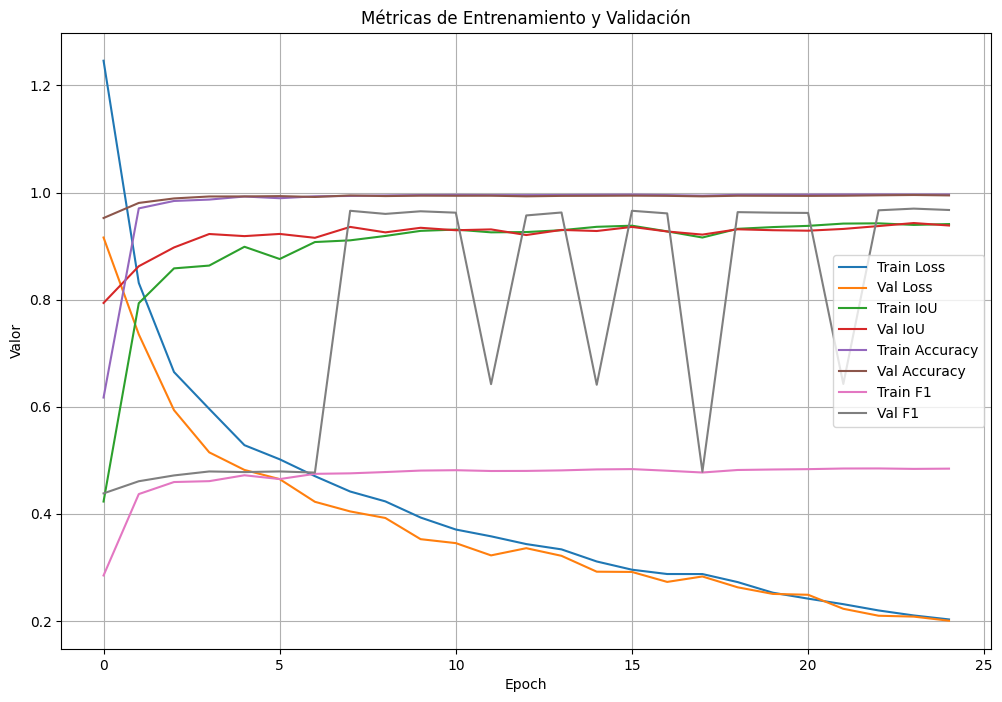

In [26]:
import time  # LINEA NUEVA
import pandas as pd  # LINEA NUEVA
import GPUtil  # LINEA NUEVA
from sklearn.metrics import precision_score, recall_score  # LINEA NUEVA

# ===============================
# ENTRENAMIENTO (CONGELADO)
# ===============================
if criterion_selected == "CrossEntropySmoothing":
    criterion = CrossEntropySmoothing(label_smoothing=0.1)
elif criterion_selected == "CrossEntropy":
    criterion = nn.CrossEntropyLoss()

if optimizer_selected == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)
elif optimizer_selected == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)

if scheduler_selected == "StepLR":
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
elif scheduler_selected == "ReduceLROnPlateau":
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
elif scheduler_selected == "CosineAnnealingLR":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

metrics = {  # LINEA NUEVA
    "epoch": [],  # LINEA NUEVA
    "train_loss": [], "train_iou": [], "train_precision": [], "train_recall": [], "train_f1": [], "train_acc": [],  # LINEA NUEVA
    "val_loss": [], "val_iou": [], "val_precision": [], "val_recall": [], "val_f1": [], "val_acc": [],  # LINEA NUEVA
    "lr": [], "epoch_time": [], "gpu_mem_mb": []  # LINEA NUEVA
}

patience = 10
patience_counter = 0
best_val_loss = float("inf")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    start_time = time.time()  # LINEA NUEVA
    model.train()
    running_loss = 0.0
    train_preds, train_targets = [], []  # LINEA NUEVA

    for images, masks, _ in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())  # LINEA NUEVA
        train_targets.extend(masks.cpu().numpy())  # LINEA NUEVA

    # TRAIN METRICS
    train_preds_flat = np.array(train_preds).flatten()  # LINEA NUEVA
    train_targets_flat = np.array(train_targets).flatten()  # LINEA NUEVA
    train_iou = compute_iou(np.array(train_preds), np.array(train_targets))  # LINEA NUEVA
    train_acc = pixel_accuracy(np.array(train_preds), np.array(train_targets))  # LINEA NUEVA
    train_precision = precision_score(train_targets_flat, train_preds_flat, average="macro", zero_division=0)  # LINEA NUEVA
    train_recall = recall_score(train_targets_flat, train_preds_flat, average="macro", zero_division=0)  # LINEA NUEVA
    train_f1 = f1_score(train_targets_flat, train_preds_flat, average="macro", zero_division=0)  # LINEA NUEVA

    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for images, masks, _ in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(masks.cpu().numpy())

    val_preds_flat = np.array(val_preds).flatten()
    val_targets_flat = np.array(val_targets).flatten()
    val_iou = compute_iou(np.array(val_preds), np.array(val_targets))
    val_acc = pixel_accuracy(np.array(val_preds), np.array(val_targets))
    val_precision = precision_score(val_targets_flat, val_preds_flat, average="macro", zero_division=0)
    val_recall = recall_score(val_targets_flat, val_preds_flat, average="macro", zero_division=0)
    val_f1 = f1_score(val_targets_flat, val_preds_flat, average="macro", zero_division=0)

    # GPU + Tiempo
    epoch_time = time.time() - start_time  # LINEA NUEVA
    gpu_mem = GPUtil.getGPUs()[0].memoryUsed if torch.cuda.is_available() else 0  # LINEA NUEVA

    # Log CSV
    metrics["epoch"].append(epoch)  # LINEA NUEVA
    metrics["train_loss"].append(running_loss / len(train_loader))
    metrics["train_iou"].append(train_iou)
    metrics["train_precision"].append(train_precision)
    metrics["train_recall"].append(train_recall)
    metrics["train_f1"].append(train_f1)
    metrics["train_acc"].append(train_acc)
    metrics["val_loss"].append(val_loss / len(val_loader))
    metrics["val_iou"].append(val_iou)
    metrics["val_precision"].append(val_precision)
    metrics["val_recall"].append(val_recall)
    metrics["val_f1"].append(val_f1)
    metrics["val_acc"].append(val_acc)
    metrics["lr"].append(optimizer.param_groups[0]["lr"])  # LINEA NUEVA
    metrics["epoch_time"].append(epoch_time)  # LINEA NUEVA
    metrics["gpu_mem_mb"].append(gpu_mem)  # LINEA NUEVA

    # Guardar CSV
    pd.DataFrame(metrics).to_csv("checkpoints/metrics_log.csv", index=False)  # LINEA NUEVA

    train_loss = metrics["train_loss"][-1]
    val_loss = metrics["val_loss"][-1]
    print(f"[Train] Epoch {epoch+1} | Loss: {train_loss:.4f} | IoU: {train_iou:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"[Val]   Epoch {epoch+1} | Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    scheduler.step(val_loss if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) else None)

    # EARLY STOPPING
    if early_stopping:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "checkpoints/best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
                break

# Cargar mejor modelo
if early_stopping:
    model.load_state_dict(torch.load("checkpoints/best_model.pt"))
    print("✅ Modelo óptimo cargado desde early stopping.")

# ===============================
# GUARDAR MODELO
# ===============================
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/dpt_finetuned.pt")
print("Modelo guardado en checkpoints/dpt_finetuned.pt")

# ===============================
# GRÁFICAS
# ===============================
plt.figure(figsize=(12, 8))
plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["val_loss"], label="Val Loss")
plt.plot(metrics["train_iou"], label="Train IoU")
plt.plot(metrics["val_iou"], label="Val IoU")
plt.plot(metrics["train_acc"], label="Train Accuracy")
plt.plot(metrics["val_acc"], label="Val Accuracy")
plt.plot(metrics["train_f1"], label="Train F1")
plt.plot(metrics["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Valor")
plt.title("Métricas de Entrenamiento y Validación")
plt.grid(True)
plt.legend()
plt.savefig("checkpoints/metrics_plot.png")
plt.show()


In [27]:
import pandas as pd  # Asegurate de tenerlo ya importado
import matplotlib.pyplot as plt
import os

# LINEA NUEVA: Leer el CSV exportado
metrics = pd.read_csv("checkpoints/metrics_log.csv")  # LINEA NUEVA

# LINEA NUEVA: Convertir a listas si es necesario
metrics = {col: metrics[col].tolist() for col in metrics.columns}  # LINEA NUEVA


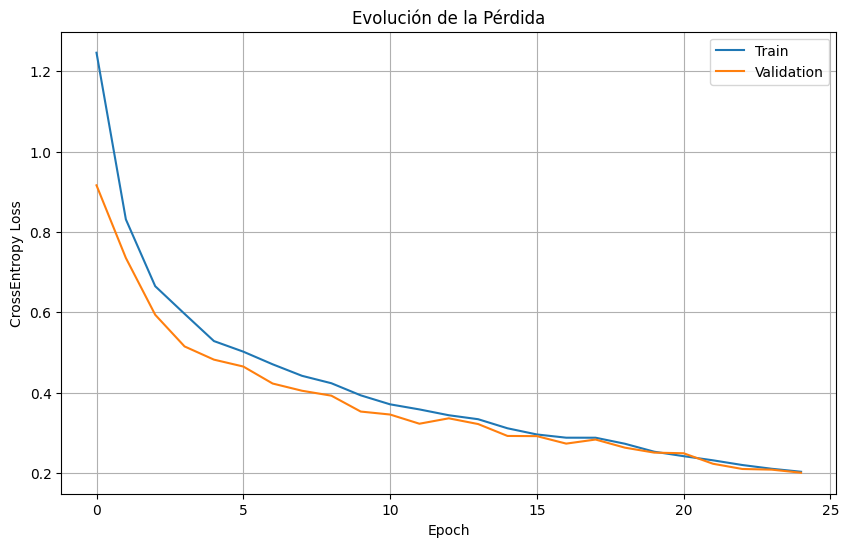

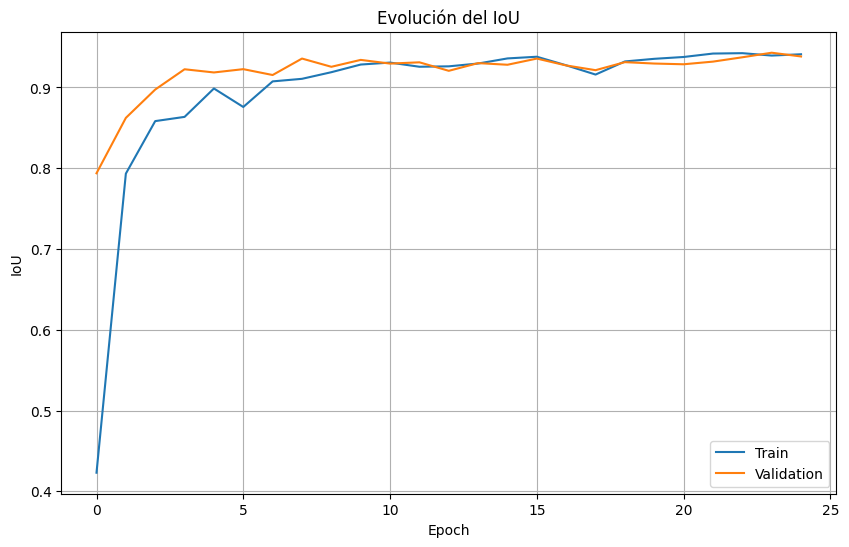

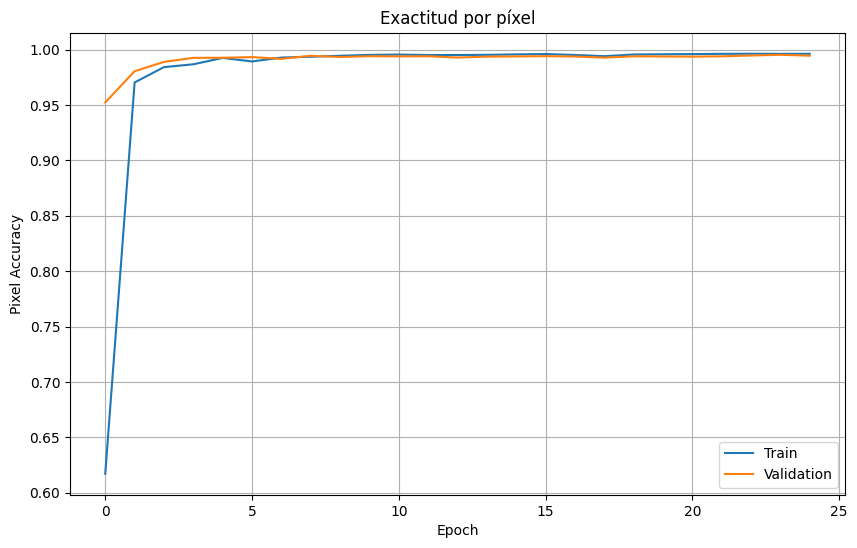

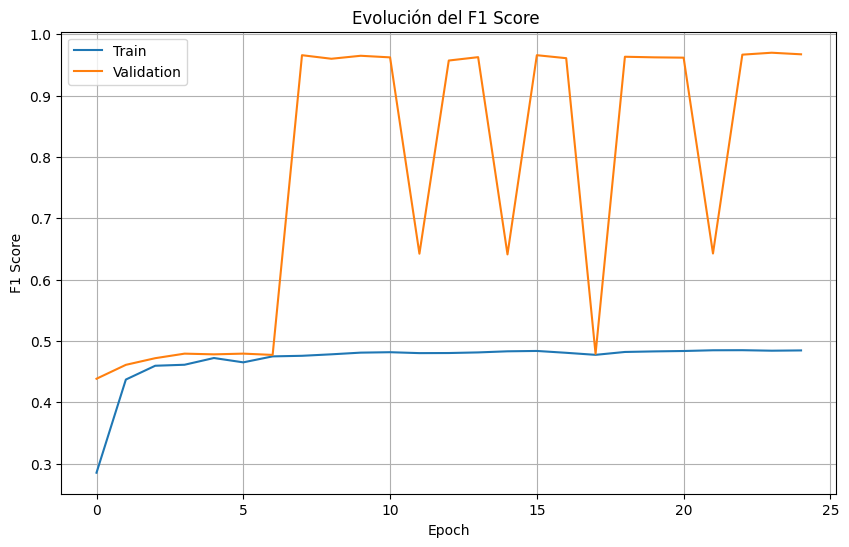

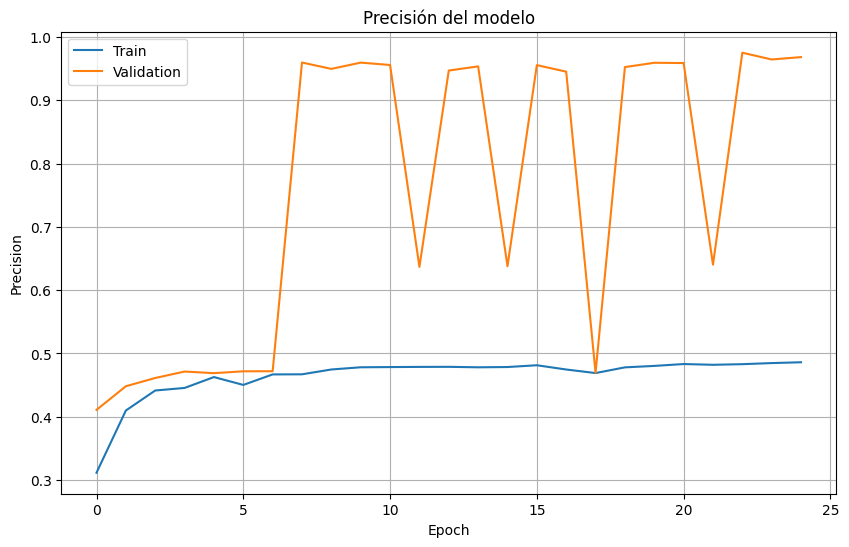

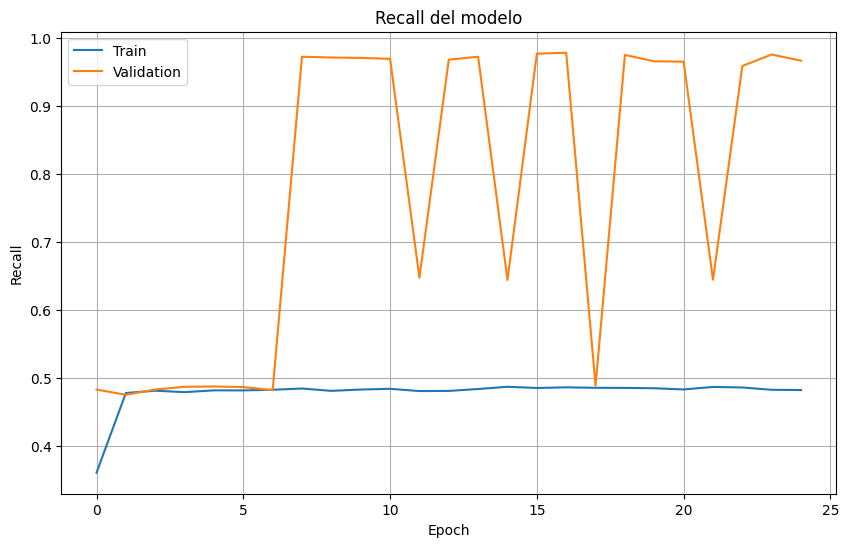

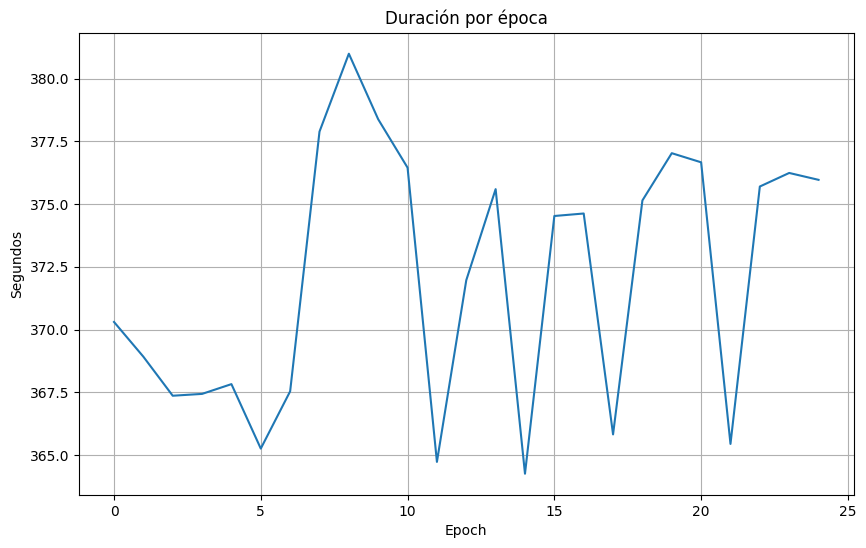

In [28]:
import matplotlib.pyplot as plt
import os

# Asegura carpeta de salida
os.makedirs("checkpoints/metric_plots", exist_ok=True)

def plot_metric(train_values, val_values, title, ylabel, filename):
    plt.figure(figsize=(10, 6))
    plt.plot(train_values, label="Train")
    plt.plot(val_values, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"checkpoints/metric_plots/{filename}.png")
    plt.show()

# 1. Pérdida (Loss) para detectar overfitting/underfitting
plot_metric(
    metrics["train_loss"],
    metrics["val_loss"],
    "Evolución de la Pérdida",
    "CrossEntropy Loss",
    "loss_comparison"
)

# 2. IoU (Intersección sobre Unión) - Métrica clave para segmentación
plot_metric(
    metrics["train_iou"],
    metrics["val_iou"],
    "Evolución del IoU",
    "IoU",
    "iou_comparison"
)

# 3. Pixel Accuracy - Proporción de píxeles correctamente clasificados
plot_metric(
    metrics["train_acc"],
    metrics["val_acc"],
    "Exactitud por píxel",
    "Pixel Accuracy",
    "accuracy_comparison"
)

# 4. F1 Score - Balance entre precisión y recall
plot_metric(
    metrics["train_f1"],
    metrics["val_f1"],
    "Evolución del F1 Score ",
    "F1 Score",
    "f1_comparison"
)
# 5. Precision
plot_metric(
    metrics["train_precision"],
    metrics["val_precision"],
    "Precisión del modelo",
    "Precision",
    "precision_comparison"
)

# 6. Recall
plot_metric(
    metrics["train_recall"],
    metrics["val_recall"],
    "Recall del modelo",
    "Recall",
    "recall_comparison"
)

# 7. Tiempo por época
plt.figure(figsize=(10, 6))
plt.plot(metrics["epoch_time"], label="Duración por época")
plt.xlabel("Epoch")
plt.ylabel("Segundos")
plt.title("Duración por época")
plt.grid(True)
plt.savefig("checkpoints/metric_plots/epoch_time.png")
plt.show()

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

# Cargar métricas desde CSV
metrics_path = "checkpoints/metrics_log.csv"
metrics_df = pd.read_csv(metrics_path)

# Crear carpeta de salida
os.makedirs("checkpoints/metric_plots", exist_ok=True)

# Función para graficar y agregar al PDF
def plot_metric_to_pdf(pdf, x, train_values, val_values, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(x, train_values, label="Train")
    plt.plot(x, val_values, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

# Crear PDF
pdf_path = "checkpoints/metric_plots/metric_report.pdf"
with PdfPages(pdf_path) as pdf:
    x = metrics_df["epoch"]

    plot_metric_to_pdf(pdf, x, metrics_df["train_loss"], metrics_df["val_loss"], "Evolución de la Pérdida", "CrossEntropy Loss")
    plot_metric_to_pdf(pdf, x, metrics_df["train_iou"], metrics_df["val_iou"], "Evolución del IoU", "IoU")
    plot_metric_to_pdf(pdf, x, metrics_df["train_acc"], metrics_df["val_acc"], "Exactitud por píxel", "Pixel Accuracy")
    plot_metric_to_pdf(pdf, x, metrics_df["train_f1"], metrics_df["val_f1"], "Evolución del F1 Score", "F1 Score")
    plot_metric_to_pdf(pdf, x, metrics_df["train_precision"], metrics_df["val_precision"], "Precisión del modelo", "Precision")
    plot_metric_to_pdf(pdf, x, metrics_df["train_recall"], metrics_df["val_recall"], "Recall del modelo", "Recall")
    
    # Plot tiempo por época
    plt.figure(figsize=(10, 6))
    plt.plot(x, metrics_df["epoch_time"], label="Duración por época")
    plt.xlabel("Epoch")
    plt.ylabel("Segundos")
    plt.title("Duración por época")
    plt.grid(True)
    pdf.savefig()
    plt.close()

pdf_path


'checkpoints/metric_plots/metric_report.pdf'

In [30]:
!cp checkpoints/metric_plots/metric_report.pdf ./metric_report.pdf
!cp checkpoints/metrics_log.csv ./metrics_log.csv

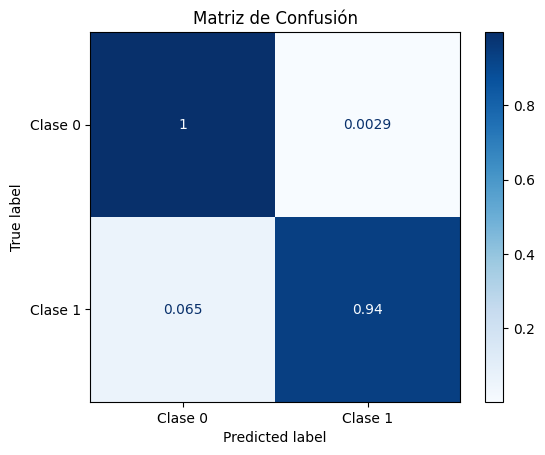

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, device, num_classes=2, normalize=True, title="Matriz de Confusión"):
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for images, masks, _ in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(masks.cpu().numpy().flatten())

    cm = confusion_matrix(all_targets, all_preds, labels=list(range(num_classes)), normalize='true' if normalize else None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Clase {i}" for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.grid(False)
    plt.savefig("checkpoints/confusion_matrix.png")
    plt.show()

plot_confusion_matrix(model, val_loader, DEVICE, num_classes=2)


In [32]:
# ===============================
# EVALUADOR DE MODELO
# ===============================
def evaluate_model(model_path, dataloader, device, num_classes=2, pretrained=True):
    if pretrained:
        model = DPTSegmentationModel(
            num_classes=num_classes,
            path=model_path,
            backbone="vitl16_384",
        )
    else:
        model = DPTSegmentationModel(
            num_classes=num_classes,
            path=None,
            backbone="vitl16_384",
        )
        model.load_partial_weights(model_path)

    model.to(device)
    model.eval()

    iou_scores = []
    pixel_accuracies = []
    f1_scores = []

    with torch.no_grad():
        for images, masks, labels in tqdm(dataloader, desc=f"Evaluando {model_path}"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for p, t in zip(preds, masks):
                p_np = p.cpu().numpy()
                t_np = t.cpu().numpy()
                iou_scores.append(compute_iou(p_np, t_np, num_classes))
                pixel_accuracies.append(pixel_accuracy(p_np, t_np))
                f1_scores.append(f1_score(t_np.flatten(), p_np.flatten(), average="macro"))

    return {
        "IoU": np.nanmean(iou_scores),
        "Pixel Accuracy": np.mean(pixel_accuracies),
        "F1 Score": np.mean(f1_scores)
    }

In [33]:
eval_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

eval_dataset = RoadSignSegmentationDataset(DATASET_PATH, transform=eval_transform)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluación
print("Evaluando modelo preentrenado...")
results_pre = evaluate_model("DPT/weights/dpt_large-ade20k-b12dca68.pt", eval_loader, DEVICE, NUM_CLASSES, pretrained=True)
print("Modelo Preentrenado:", results_pre)

print("Evaluando modelo fine-tuned...")
results_fine = evaluate_model("checkpoints/dpt_finetuned.pt", eval_loader, DEVICE, NUM_CLASSES, pretrained=False)
print("Modelo Fine-Tuned:", results_fine)


Evaluando modelo preentrenado...
Cargando 438 de 442 parámetros del checkpoint.


Evaluando DPT/weights/dpt_large-ade20k-b12dca68.pt: 100%|██████████| 61/61 [03:00<00:00,  2.97s/it]


Modelo Preentrenado: {'IoU': 0.07551689431698294, 'Pixel Accuracy': 0.28897810180157546, 'F1 Score': 0.11211870650237422}
Evaluando modelo fine-tuned...
Cargando 442 de 442 parámetros del checkpoint.


Evaluando checkpoints/dpt_finetuned.pt: 100%|██████████| 61/61 [03:15<00:00,  3.21s/it]

Modelo Fine-Tuned: {'IoU': 0.8667126479617391, 'Pixel Accuracy': 0.996580400902206, 'F1 Score': 0.8974008433611134}


In [34]:
# ================================================
# INTERACTIVO: ELECCIÓN DE MODELO + SUBIDA DE IMAGEN
# ================================================
from IPython.display import display
from ipywidgets import Dropdown, FileUpload
import io
from PIL import Image
import torch
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

# -------- Dropdown para elegir modelo ----------
model_selector = Dropdown(
    options=[('Fine-tuned (model)', 'model'), ('Preentrenado (model2)', 'model2')],
    value='model',
    description='Modelo:',
)
display(model_selector)

# -------- Subida de imagen ----------
uploader = FileUpload(accept='image/*', multiple=False)
display(uploader)


Dropdown(description='Modelo:', options=(('Fine-tuned (model)', 'model'), ('Preentrenado (model2)', 'model2'))…

FileUpload(value=(), accept='image/*', description='Upload')

In [41]:
model2 = DPTSegmentationModel(
            num_classes=NUM_CLASSES,
            path=None,
            backbone="vitl16_384",
        )
model2.load_partial_weights("DPT/weights/dpt_large-ade20k-b12dca68.pt")

Cargando 438 de 442 parámetros del checkpoint.


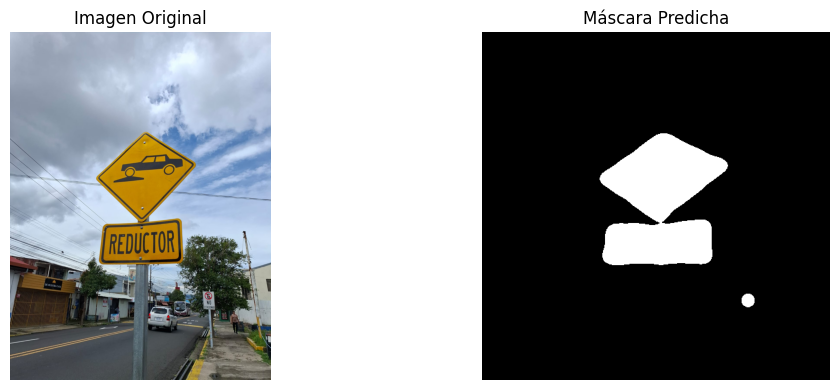

In [51]:
# ================================================
# PROCESAMIENTO Y PREDICCIÓN - VERSIÓN ROBUSTA
# ================================================

if uploader.value:
    # Detectar tipo de estructura
    if isinstance(uploader.value, dict):
        uploaded_file = list(uploader.value.values())[0]
    elif isinstance(uploader.value, tuple):
        uploaded_file = uploader.value[0]
    else:
        raise ValueError("Formato de archivo no reconocido")

    # Obtener imagen
    image_bytes = uploaded_file['content']
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    orig_image = image.copy()

    # Transformación
    transform = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Selección de modelo
    selected_model = model if model_selector.value == 'model' else model2
    selected_model.to(DEVICE)
    selected_model.eval()

    with torch.no_grad():
        output = selected_model(input_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Visualización
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_image)
    plt.title("Imagen Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Máscara Predicha")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("⬆️ Subí una imagen para visualizar la predicción.")


In [36]:
# Descongelar todo
for param in model.parameters():
    param.requires_grad = True

# O: solo descongelar encoder
for param in model.pretrained.parameters():
    param.requires_grad = True

# Nuevo optimizador con lr más bajo
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [37]:
!mv /kaggle/working/checkpoints/dpt_finetuned.pt /kaggle/working/

In [38]:
!ls -la /kaggle/working/dpt_finetuned.pt
!date

ls: cannot access '/kaggle/working/output/dpt_finetuned.pt': No such file or directory
Tue Jun 17 05:25:06 AM UTC 2025
